# Computational Intelligence CI2024_lab2
> - Author: Daniel Bologna
> - ID: 310582

## The Traveling Salesman Problem
- [Travelling salesman problem - Wikipedia](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

### Import libraries

In [1]:
import functools
import logging
from itertools import combinations # Return r length subsequences of elements from the input iterable.
import pandas as pd
import numpy as np
from geopy.distance import geodesic ## compute distance between points
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random

from icecream import ic
logging.basicConfig(level=logging.DEBUG)

from dataclasses import dataclass

from enum import Enum

## DATA LOADING

In [2]:
def _load_cities(city_name : str) -> tuple[pd.DataFrame, np.ndarray]:
    """Loads TSP cities from CSV file.
    Args:
        city_file_path (str): The name of the city.
    Returns:
        tuple[pd.DataFrame, np.ndarray]
    """
    CITIES = pd.read_csv(f'cities/{city_name}.csv', header=None, names=['name', 'lat', 'lon'])
    DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
    for c1, c2 in combinations(CITIES.itertuples(), 2):
        DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
            (c1.lat, c1.lon), (c2.lat, c2.lon)
        ).km
    return CITIES, DIST_MATRIX

def _to_pandas_table(matrix, x_names=None, y_names=None):
    """Returns a dataframe from a matrix"""
    return pd.DataFrame(matrix, index=x_names, columns=y_names)

In [ ]:
city_name = "china"
CITIES, DIST_MATRIX = _load_cities(city_name)
CITIES.head(10)

In [ ]:
#_to_pandas_table(DIST_MATRIX, [str(_) for _ in CITIES['name']], [str(_) for _ in CITIES['name']])

In [ ]:
def counter(fn):
    """Simple decorator for counting number of calls"""

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper

@counter
def tsp_cost(tsp : np.ndarray) -> float:
    """Compute the cost of the path as the sum of the cities' distances."""
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))

    tot_cost = 0.0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

# Visualization

Simple function that plot a graph

In [ ]:
def _print_graph(solution, points=True, lines=True, p_color = "red", l_color = "red", title=""):
    """Plot the graph from a coordinate matrix"""
    coord = [
        [CITIES.at[i, "lon"] for i in solution],
        [CITIES.at[i, "lat"] for i in solution]
    ]
    plt.axis("off")
    plt.title(title)
    if points: plt.scatter( coord[0], coord[1], color=p_color)
    if lines: plt.plot( coord[0], coord[1], color=l_color)
    plt.show()

In [ ]:
def fitness(sequence):
    return -tsp_cost(sequence)

# Nearest Neighbor approach

> Start from a point, then choose the nearest point in the list of cities. Repeat until completion. 

ic| final_cost: '46244.33295267395 km'


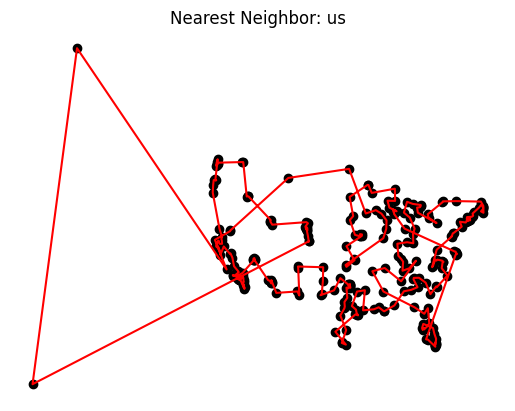

In [ ]:
def _nn_approach(cities, dist_mat):
    visited = np.full(len(cities), False)
    dist = dist_mat.copy()

    # Choose a random city to start
    city = np.random.randint(0, len(cities))

    # Create a solution as a list of integers (city's index)
    tsp_sol = list()

    # Append the first city to the solution and mark as visited
    tsp_sol.append(int(city))
    visited[city] = True

    while not np.all(visited):
        # Set the city's column as inf distance to avoid 
        # calculating the distance between a city and itself
        dist[:, city] = np.inf

        # Find the closest city
        closest = np.argmin(dist[city])

        # Mark it as visited, push it to the solution and se the current city as the closest
        visited[closest] = True
        city = closest
        tsp_sol.append(int(city))

    # In the end add the first city at the end to create a cycle
    tsp_sol.append(int(tsp_sol[0]))
    return tsp_sol

EPOCHS = 1000
tsp_sol = _nn_approach(CITIES, DIST_MATRIX)
tsp_fit = fitness(tsp_sol)
for i in range(EPOCHS):
    new_tsp_sol = _nn_approach(CITIES, DIST_MATRIX)
    new_tsp_fit = fitness(new_tsp_sol)
    if new_tsp_fit > tsp_fit:
        tsp_sol = new_tsp_sol
        tsp_fit = new_tsp_fit

# Print the result and plot the graph
final_cost = f"{abs(tsp_fit)} km"
ic(final_cost)
_print_graph(tsp_sol, p_color="black", title=f"Nearest Neighbor: {city_name}")

# EA approach

In [ ]:
@dataclass # this is a decorator https://www.geeksforgeeks.org/decorators-in-python/
class Individual:
    genome: np.ndarray
    fitness : float = None

## SETTINGS

In [ ]:
class SEL_TYPE(Enum):
    UNIFORM = 0
    TOURNAMENT = 1

class XO_TYPE(Enum):
    INV_OVER = 0

class MUT_TYPE(Enum):
    INSERT = 0
    INV = 1

class HEURISTIC_TYPE(Enum):
    CLASSIC = 0
    MODERN = 1
    HYPER_MODERN = 2


POPULATION_SIZE = 100
OFFSPRING_SIZE = 1_000
MAX_GENERATIONS = 1_000
GEN_OP_PROBABILITY = .4

TOURNAMENT_SIZE = 3

## best so far
# stedy state
# mutation(p, type=MUT_TYPE.INV)
# POPULATION_SIZE = 100
# OFFSPRING_SIZE = 1_000
# MAX_GENERATIONS = 1_000
# GEN_OP_PROBABILITY = .4

# TOURNAMENT_SIZE = 3

In [ ]:
def parent_selection(population, type=SEL_TYPE.UNIFORM):
    if type == SEL_TYPE.UNIFORM:
        candidates = sorted(population, key=lambda c: c.fitness, reverse=True)
        return candidates[0]
    if type == SEL_TYPE.TOURNAMENT:
        candidates = sorted(np.random.choice(population, TOURNAMENT_SIZE, replace=False),
                            key=lambda c: c.fitness,
                            reverse=True)
        return candidates[0]
        

def mutation(p, type=MUT_TYPE.INSERT):
    if type == MUT_TYPE.INSERT:
        # get two random elements
        indices = sorted(np.random.choice(p.genome, 2, replace=False), key=lambda x:x)

        o = p.genome[0:indices[0]] + [p.genome[indices[0]],p.genome[indices[1]]] + p.genome[indices[0] + 1: indices[1]] + p.genome[indices[1] + 1: len(p.genome)]
        return Individual(genome=o, fitness=fitness(o+[o[0]]))
    elif type == MUT_TYPE.INV:
        # get two random indices
        indices = sorted(np.random.choice(p.genome, 2, replace=False), key=lambda x:x)
        # invert the genome squend between the two indices
        o = p.genome[0:indices[0]] + p.genome[indices[0]: indices[1]+1][::-1] + p.genome[indices[1] + 1: len(p.genome)]
        return Individual(genome=o, fitness=fitness(o+[o[0]]))


def xover(p1, p2, type=XO_TYPE.INV_OVER):
    """Simple invert over crossover"""
    if type == XO_TYPE.INV_OVER:
        # Get random edge from second parent
        index = np.random.randint(0, len(p2.genome) - 1)
        edge = [p2.genome[index], p2.genome[index+1]]

        # get the edge's vertices indices from the first parent
        edge_inices = [p1.genome.index(i) for i in edge]
        edge_inices = sorted(edge_inices, key=lambda x: x)

        # combine the data to get the offspring
        o = p1.genome[0:edge_inices[0]] + edge + p1.genome[edge_inices[0]+1:edge_inices[1]][::-1] + p1.genome[edge_inices[1]+1:len(p1.genome)]
        return Individual(genome=o, fitness=fitness(o+[o[0]]))

In [ ]:
# Generate population
def _init_population():
    population = list()
    for i in range(POPULATION_SIZE):
        genome = _nn_approach(CITIES, DIST_MATRIX)[: len(CITIES)]
        population.append(Individual(genome=genome, fitness=fitness(genome + [genome[0]]))) # leve out the last item but consider it for the fitness
    return population

## GENETIC OPERATORS

In [ ]:
def _modern_go(population, offspring, sel_type=SEL_TYPE.TOURNAMENT):
    """Modern recombination and mutation"""
    offspring = list()
    for _ in range(OFFSPRING_SIZE):
        # USING MODERN APPROACH:
        # Perform xover
        # take 2 parents
        p1 = parent_selection(population, type=sel_type)
        p2 = parent_selection(population, type=sel_type)
        # recombine them
        o = xover(p1, p2)
        
        if np.random.random() < GEN_OP_PROBABILITY:
            # Perform MUTATION usign the offspring with certain probability
            # mutate the parent to get the offspring
            mut = mutation(o)
            # put the result in the offspring
            offspring.append(mut)
        else:
            # put the result in the offspring
            offspring.append(o)    
    return offspring

def _hyper_modern_go(population, offspring, sel_type=SEL_TYPE.TOURNAMENT):
    """Hyper modern recombination and mutation"""
    offspring = list()
    for _ in range(OFFSPRING_SIZE):
        # USING HYPER MODERN APPROACH:
        # RANDOMLY CHOOSE GENETIC OP
        if np.random.random() < GEN_OP_PROBABILITY:
            # DO MUTATION
            # take 1 parent
            p = parent_selection(population, type=sel_type)
            # mutate the parent to get the offspring
            o = mutation(p, type=MUT_TYPE.INV)
        else:
            # DO XOVER
            # take 2 parents
            p1 = parent_selection(population, type=sel_type)
            p2 = parent_selection(population, type=sel_type)
            # recombine them
            o = xover(p1, p2)
        
        # put the result in the offspring
        offspring.append(o)
    return offspring

## STEP

In [ ]:
def _step(population, type=HEURISTIC_TYPE.HYPER_MODERN):
    # Select geneti operator
    offspring = list()
    if type == HEURISTIC_TYPE.MODERN:
        offspring = _modern_go(population, offspring)
    elif type == HEURISTIC_TYPE.HYPER_MODERN:
        offspring = _hyper_modern_go(population, offspring)

    # steady state
    # In the end add the newly generated offspring to the population
    population.extend(offspring)
    population.sort(key=lambda i : i.fitness, reverse=True)

    # SURVIVOR SELECTION
    # Go for a simple survivor selection and return to the population size
    population = population[:POPULATION_SIZE]

    # # generational
    # population = sorted(offspring, key=lambda i : i.fitness, reverse=True)
    # population = population[:POPULATION_SIZE]

    return population

  0%|          | 0/1000 [00:00<?, ?it/s]

ic| tsp_cost(best_sol): 39336.22763712252, tsp_cost.calls: 1001102


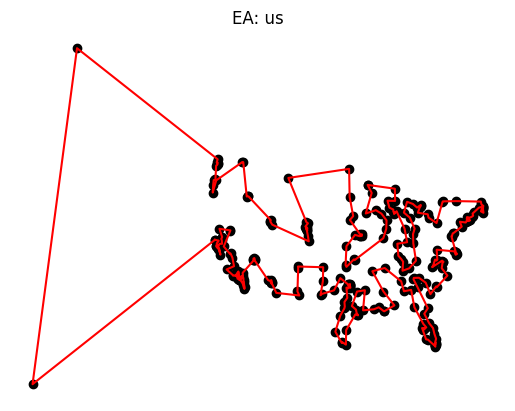

In [ ]:
starting_population = _init_population()
current_solution = starting_population.copy()
best_so_far = current_solution[0]
for i in tqdm(range(MAX_GENERATIONS)):
    current_solution = _step(current_solution, HEURISTIC_TYPE.HYPER_MODERN)
    if current_solution[0].fitness > best_so_far.fitness:
        best_so_far = current_solution[0]

best_sol = best_so_far.genome
best_sol = best_sol + [best_sol[0]]

ic(tsp_cost(best_sol), tsp_cost.calls)
_print_graph(best_sol, p_color="black", title=f"EA: {city_name}")